In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"avinashchowdhary","key":"3f745b2354141fd6057f1ea06b0d7113"}'}

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mahmoudima/mma-facial-expression


Dataset URL: https://www.kaggle.com/datasets/mahmoudima/mma-facial-expression
License(s): unknown
 92% 153M/166M [00:01<00:00, 105MB/s] 
100% 166M/166M [00:01<00:00, 98.0MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile("mma-facial-expression.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/mma_facial_expression")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from itertools import chain
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Define transformations
emotion_trans = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load train and test datasets
train_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/train', transform=emotion_trans)
test_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/test', transform=emotion_trans)



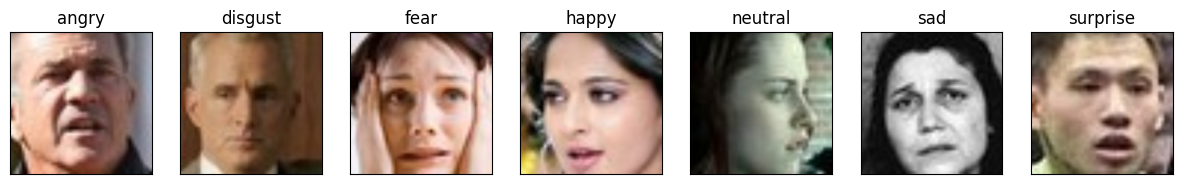

In [ ]:
import matplotlib.pyplot as plt

# Define your 7 emotion classes
class_names = train_emotion.classes  # Automatically retrieves class names from the dataset

# Plot images from each class
fig = plt.figure(figsize=(15, 5))
num_classes = len(class_names)
for i in range(num_classes):
    ax = fig.add_subplot(1, num_classes, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    # Find an image for each class and plot it
    img, label = next((img, label) for img, label in test_emotion if label == i)
    img = img.permute(1, 2, 0).numpy()  # Convert image to numpy array
    img = (img - img.min()) / (img.max() - img.min())  # Rescale to [0, 1] for proper visualization
    plt.imshow(img)
plt.show()


In [ ]:
emotion_trans = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4630, 0.4530, 0.3405], std = [0.2862, 0.2758, 0.2845])
])

In [ ]:
train_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/train', transform=emotion_trans)
test_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/test', transform=emotion_trans)


In [ ]:
from torch.utils.data import WeightedRandomSampler,DataLoader
import torch
from collections import Counter


class_counts = Counter(train_emotion.targets)
class_weights = [1.0 / class_counts[i] for i in range(len(train_emotion.classes))]
sample_weights = [class_weights[label] for _, label in train_emotion.samples]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_emotion, batch_size=32, sampler=sampler)

Class distribution after sampling:
neutral: 13235 samples
happy: 13278 samples
angry: 13375 samples
disgust: 13278 samples
sad: 13180 samples
surprise: 13259 samples
fear: 13363 samples


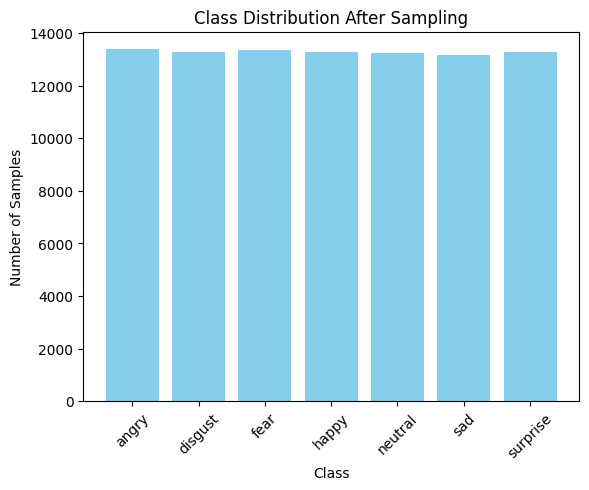

In [ ]:
from collections import Counter

sampled_indices = list(sampler)

sampled_labels = [train_emotion.targets[idx] for idx in sampled_indices]

sampled_class_counts = Counter(sampled_labels)

print("Class distribution after sampling:")
for class_idx, count in sampled_class_counts.items():
    print(f"{train_emotion.classes[class_idx]}: {count} samples")

import matplotlib.pyplot as plt

classes = [train_emotion.classes[idx] for idx in range(len(train_emotion.classes))]
class_sizes = [sampled_class_counts.get(idx, 0) for idx in range(len(train_emotion.classes))]

plt.bar(classes, class_sizes, color='skyblue')
plt.title("Class Distribution After Sampling")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()


In [ ]:
from torch.utils.data import WeightedRandomSampler,DataLoader
import torch

# Calculate class weights
class_counts = Counter(train_emotion.targets)
class_weights = [1.0 / class_counts[i] for i in range(len(train_emotion.classes))]
sample_weights = [class_weights[label] for _, label in train_emotion.samples]

# Create sampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Use the sampler in DataLoader
train_loader = DataLoader(train_emotion, batch_size=32, sampler=sampler)


In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(0, n_epochs):
        model.train()
        loss_train = 0.0
        for inputs, labels in train_loader:


            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 0 or epoch == n_epochs - 1 or epoch % 1 == 0:
            print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))


In [ ]:
def test(model, train_loader, test_loader):
  model.eval()
  lls=[0,1,2,3,4,5,6,7,8,9]
  predict_train = []
  predict_test = []
  labels_train = []
  labels_test = []
  with torch.no_grad():
    for inputs, labels in train_loader:
      outputs = model(inputs)
      index_, predicted = torch.max(outputs, dim=1)
      predict_train.append(predicted.tolist())
      labels_train.append(labels.tolist())

    for inputs, labels in test_loader:
      outputs = model(inputs)
      index_, predicted = torch.max(outputs, dim=1)
      predict_test.append(predicted.tolist())
      labels_test.append(labels.tolist())

    print("Confusion matrix on train:\n",  confusion_matrix(list(chain(*labels_train)), list(chain(*predict_train)), labels=lls))
    print()
    print("Classification report on train:\n",  classification_report(list(chain(*labels_train)), list(chain(*predict_train)), labels=lls))
    print()
    print("Confusion matrix on test:\n", confusion_matrix(list(chain(*labels_test)), list(chain(*predict_test)), labels =lls))
    print()
    print("Classification report on test:\n",  classification_report(list(chain(*labels_test)), list(chain(*predict_test)), labels=lls))




In [ ]:
train_loader_emotion = torch.utils.data.DataLoader(train_emotion, batch_size=32, shuffle=True)
test_loader_emotion = torch.utils.data.DataLoader(test_emotion, batch_size=32, shuffle=False)


In [ ]:
class neural_network(nn.Module):
    def __init__(self,  in_size, hidden_size1,hidden_size2, out_size):
        super().__init__()
        self.network = nn.Sequential(
          nn.Linear(in_size, hidden_size1),
          nn.ReLU(),
          nn.Linear(hidden_size1, hidden_size2),
          nn.ReLU(),
          nn.Linear(hidden_size2, out_size))

    def forward(self, x):
        x_reshape=x.view(x.shape[0],-1)
        out = self.network(x_reshape)
        return out.squeeze()

# Random Search

In [ ]:
import random

batch_sizes = [16, 32, 64, 128]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
hidden_layer_configs = [256, 128, 64]
activation_functions = [nn.ReLU(), nn.Tanh(), nn.Sigmoid()]
layers_no = [1, 2, 3]
optimizers = [('Adam', optim.Adam), ('SGD', optim.SGD), ('RMSprop', optim.RMSprop)]
n_iterations = 8
best_accuracy = 0
best_params = {}

for i in range(n_iterations):
    batch_size = random.choice(batch_sizes)
    learning_rate = random.choice(learning_rates)
    hidden_sizes = random.choice(hidden_layer_configs)
    activation_fn = random.choice(activation_functions)
    layers = random.choice(layers_no)

    optimizer_name, optimizer_class = random.choice(optimizers)

    if layers == 3:
        class neural_network(nn.Module):
            def __init__(self, in_size, hidden_size1, out_size, activation_fn):
                super().__init__()
                self.network = nn.Sequential(
                    nn.Linear(in_size, hidden_size1),
                    activation_fn,
                    nn.Linear(hidden_size1, hidden_size1 // 2),
                    activation_fn,
                    nn.Linear(hidden_size1 // 2, (hidden_size1 // 2) // 2),
                    activation_fn,
                    nn.Linear((hidden_size1 // 2) // 2, out_size)
                )

            def forward(self, x):
                x_reshape = x.view(x.shape[0], -1)
                out = self.network(x_reshape)
                return out.squeeze()

    elif layers == 2:
        class neural_network(nn.Module):
            def __init__(self, in_size, hidden_size1, out_size, activation_fn):
                super().__init__()
                self.network = nn.Sequential(
                    nn.Linear(in_size, hidden_size1),
                    activation_fn,
                    nn.Linear(hidden_size1, hidden_size1 // 2),
                    activation_fn,
                    nn.Linear(hidden_size1 // 2, out_size)
                )

            def forward(self, x):
                x_reshape = x.view(x.shape[0], -1)
                out = self.network(x_reshape)
                return out.squeeze()
    else:
        class neural_network(nn.Module):
            def __init__(self, in_size, hidden_size1, out_size, activation_fn):
                super().__init__()
                self.network = nn.Sequential(
                    nn.Linear(in_size, hidden_size1),
                    activation_fn,
                    nn.Linear(hidden_size1, out_size)
                )

            def forward(self, x):
                x_reshape = x.view(x.shape[0], -1)
                out = self.network(x_reshape)
                return out.squeeze()

    train_loader_emotion = torch.utils.data.DataLoader(train_emotion, batch_size=batch_size, shuffle=True)
    test_loader_emotion = torch.utils.data.DataLoader(test_emotion, batch_size=batch_size, shuffle=False)

    torch.manual_seed(0)
    model = neural_network(3 * 224 * 224, hidden_sizes, 10, activation_fn)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    loss_fn = nn.CrossEntropyLoss()

    print(f"\nIteration {i+1}")
    print(f"Optimizer: {optimizer_name}")
    print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}, Layers: {layers}, Hidden Layers: {hidden_sizes}, Activation Function: {activation_fn}")

    training_loop(n_epochs=5, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader_emotion)
    test(model, train_loader_emotion, test_loader_emotion)


Iteration 1
Optimizer: SGD
Batch Size: 64, Learning Rate: 0.01, Layers: 1, Hidden Layers: 256, Activation Function: Tanh()
Epoch 0, Training loss 1.5209279475504172
Epoch 1, Training loss 1.4599990283548627
Epoch 2, Training loss 1.443422743475035
Epoch 3, Training loss 1.42793201604385
Epoch 4, Training loss 1.4144055140239982
Confusion matrix on train:
 [[  726     0   341  2414  1701   930   448     3     2     1]
 [   49     0    70  1296  1424   236   151     2     0     3]
 [  277     0   636  1585   785   952   624     0     0     0]
 [  243     0   243 21356  5142  1155   447     1     1     4]
 [  311     1   323  9532 16467  1979   755     5     6     5]
 [  309     0   334  4115  4475  2550   435     0     1     4]
 [  123     0   264  2439  2088   702  2495     2     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

Classification report on train:
               precision    recall  f1-score   support

           0       0.36      0.11      0.17      6566
           1       0.00      0.00      0.00      3231
           2       0.29      0.13      0.18      4859
           3       0.50      0.75      0.60     28592
           4       0.51      0.56      0.54     29384
           5       0.30      0.21      0.25     12223
           6       0.47      0.31      0.37      8113
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.48     92968
   macro avg       0.24      0.21      0.21     92968
weighted avg       0.44      0.48      0.44     92968


Confusion matrix on test:
 [[  83    0   47  454  233  139   84    0    0    1]
 [  13    0    8  258  304   46   25    0    1    0]
 [  36    0   68  224  135  129   98    0    0    1]
 [  41    1   40 2723

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

Classification report on test:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1041
           1       0.00      0.00      0.00       655
           2       0.00      0.00      0.00       691
           3       0.31      1.00      0.48      5459
           4       0.00      0.00      0.00      5858
           5       0.00      0.00      0.00      2177
           6       0.00      0.00      0.00      1475
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.31     17356
   macro avg       0.03      0.10      0.05     17356
weighted avg       0.10      0.31      0.15     17356


Iteration 3
Optimizer: Adam
Batch Size: 64, Learning Rate: 0.1, Layers: 1, Hidden Layers: 256, Activation Function: Sigmoid()
Epoch 0, Training loss 2.6178079450532477
Epoch 1, Training loss 2.634422139881892

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

Classification report on train:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      6566
           1       0.00      0.00      0.00      3231
           2       0.13      0.02      0.04      4859
           3       0.36      0.68      0.47     28592
           4       0.44      0.21      0.28     29384
           5       0.17      0.33      0.22     12223
           6       0.17      0.01      0.02      8113
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.32     92968
   macro avg       0.13      0.13      0.10     92968
weighted avg       0.30      0.32      0.27     92968


Confusion matrix on test:
 [[   0    0   21  634   72  311    3    0    0    0]
 [   0    0    5  375   96  175    4    0    0    0]
 [   0    0   12  411   46  215    7    0    0    0]
 [   0    0   24 3038

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

Classification report on train:
               precision    recall  f1-score   support

           0       0.38      0.10      0.16      6566
           1       0.00      0.00      0.00      3231
           2       0.36      0.12      0.18      4859
           3       0.57      0.71      0.63     28592
           4       0.49      0.73      0.59     29384
           5       0.37      0.14      0.20     12223
           6       0.50      0.32      0.39      8113
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.51     92968
   macro avg       0.27      0.21      0.22     92968
weighted avg       0.47      0.51      0.46     92968


Confusion matrix on test:
 [[  97    0   27  342  409   79   87    0    0    0]
 [  15    0    7  160  430   11   32    0    0    0]
 [  26    0   62  202  223   89   89    0    0    0]
 [  48    0   24 2229

# Random search with subset sampling

In [ ]:
from torch.utils.data import Subset
import random

subset_train_size = int(0.1 * len(train_emotion))
subset_test_size = int(0.1 * len(test_emotion))

train_indices = random.sample(range(len(train_emotion)), subset_train_size)
test_indices = random.sample(range(len(test_emotion)), subset_test_size)

# Create subsets
train_subset = Subset(train_emotion, train_indices)
test_subset = Subset(test_emotion, test_indices)

# Update DataLoaders to use subsets
train_loader_emotion = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader_emotion = DataLoader(test_subset, batch_size=32, shuffle=False)


In [ ]:
import random

batch_sizes = [16, 32, 64, 128]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
hidden_layer_configs = [256, 128, 64]
activation_functions = [nn.ReLU(), nn.Tanh(), nn.Sigmoid()]
layers_no = [1, 2, 3]
optimizers = [('Adam', optim.Adam), ('SGD', optim.SGD), ('RMSprop', optim.RMSprop)]
n_iterations = 8
best_accuracy = 0
best_params = {}

for i in range(n_iterations):
    # Randomly sample hyperparameters
    batch_size = random.choice(batch_sizes)
    learning_rate = random.choice(learning_rates)
    hidden_sizes = random.choice(hidden_layer_configs)
    activation_fn = random.choice(activation_functions)
    layers = random.choice(layers_no)

    # Randomly select an optimizer
    optimizer_name, optimizer_class = random.choice(optimizers)

    if layers == 3:
        # Three Hidden layers
        class neural_network(nn.Module):
            def __init__(self, in_size, hidden_size1, out_size, activation_fn):
                super().__init__()
                self.network = nn.Sequential(
                    nn.Linear(in_size, hidden_size1),
                    activation_fn,
                    nn.Linear(hidden_size1, hidden_size1 // 2),
                    activation_fn,
                    nn.Linear(hidden_size1 // 2, (hidden_size1 // 2) // 2),
                    activation_fn,
                    nn.Linear((hidden_size1 // 2) // 2, out_size)
                )

            def forward(self, x):
                x_reshape = x.view(x.shape[0], -1)
                out = self.network(x_reshape)
                return out.squeeze()

    elif layers == 2:
        # Two Hidden layers
        class neural_network(nn.Module):
            def __init__(self, in_size, hidden_size1, out_size, activation_fn):
                super().__init__()
                self.network = nn.Sequential(
                    nn.Linear(in_size, hidden_size1),
                    activation_fn,
                    nn.Linear(hidden_size1, hidden_size1 // 2),
                    activation_fn,
                    nn.Linear(hidden_size1 // 2, out_size)
                )

            def forward(self, x):
                x_reshape = x.view(x.shape[0], -1)
                out = self.network(x_reshape)
                return out.squeeze()
    else:
        # One Hidden layer
        class neural_network(nn.Module):
            def __init__(self, in_size, hidden_size1, out_size, activation_fn):
                super().__init__()
                self.network = nn.Sequential(
                    nn.Linear(in_size, hidden_size1),
                    activation_fn,
                    nn.Linear(hidden_size1, out_size)
                )

            def forward(self, x):
                x_reshape = x.view(x.shape[0], -1)
                out = self.network(x_reshape)
                return out.squeeze()

    # Load data with the selected batch size
    train_loader_emotion = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader_emotion = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    # Define model with the randomly selected hidden sizes and activation function
    torch.manual_seed(0)
    model = neural_network(3 * 224 * 224, hidden_sizes, 10, activation_fn)

    # Define the optimizer with the randomly selected class
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    # Define loss function
    loss_fn = nn.CrossEntropyLoss()

    print(f"\nIteration {i+1}")
    print(f"Optimizer: {optimizer_name}")
    print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}, Layers: {layers}, Hidden Layers: {hidden_sizes}, Activation Function: {activation_fn}")

    # Train the model
    training_loop(n_epochs=5, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader_emotion)
    test(model, train_loader_emotion, test_loader_emotion)


Iteration 1
Optimizer: SGD
Batch Size: 128, Learning Rate: 0.001, Layers: 2, Hidden Layers: 256, Activation Function: ReLU()
Epoch 0, Training loss 1.8597632907841304
Epoch 1, Training loss 1.6471503189165297
Epoch 2, Training loss 1.5854003853993872
Epoch 3, Training loss 1.5478206660649547
Epoch 4, Training loss 1.520118479859339
Confusion matrix on train:
 [[   7    0    1  270  322   16   71    0    0    0]
 [   2    0    0  112  170    4   14    0    0    0]
 [   3    0    0  170  217   19   94    0    0    0]
 [   4    0    1 1934  840   16   57    0    0    0]
 [   4    0    0  846 2037    8   76    0    0    0]
 [   2    0    0  411  682   42   49    0    0    0]
 [   2    0    0  273  319    5  196    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

Epoch 0, Training loss 2.1386215637807977
Epoch 1, Training loss 1.9297503935147637
Epoch 2, Training loss 1.8164720641423577
Epoch 3, Training loss 1.7503531387407485
Epoch 4, Training loss 1.7108695645854897
Confusion matrix on train:
 [[   0    0    0  445  242    0    0    0    0    0]
 [   0    0    0  156  146    0    0    0    0    0]
 [   0    0    0  378  125    0    0    0    0    0]
 [   0    0    0 1905  947    0    0    0    0    0]
 [   0    0    0 1200 1771    0    0    0    0    0]
 [   0    0    0  548  638    0    0    0    0    0]
 [   0    0    0  539  256    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       687
           1       0.00      0.00      0.00       302
           2       0.00      0.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

Epoch 0, Training loss 1.7322286702182195
Epoch 1, Training loss 1.6385549257879388
Epoch 2, Training loss 1.6231794030699012
Epoch 3, Training loss 1.6150228764912853
Epoch 4, Training loss 1.6048872029944643
Confusion matrix on train:
 [[   0    0   12  411  255    9    0    0    0    0]
 [   0    0    0  136  161    4    0    0    1    0]
 [   1    0    6  366  122    8    0    0    0    0]
 [   0    0   13 1692 1134   13    0    0    0    0]
 [   1    0    8 1275 1680    7    0    0    0    0]
 [   0    0   13  548  612   13    0    0    0    0]
 [   0    0    8  488  295    4    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       687
           1       0.00      0.00      0.00       302
           2       0.10      0.01 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 4
Optimizer: SGD
Batch Size: 64, Learning Rate: 0.0001, Layers: 2, Hidden Layers: 128, Activation Function: ReLU()
Epoch 0, Training loss 2.217646945012759
Epoch 1, Training loss 2.024177561884057
Epoch 2, Training loss 1.9209972048458988
Epoch 3, Training loss 1.8550384101802355
Epoch 4, Training loss 1.8050951680091962
Confusion matrix on train:
 [[   0    0   27  242  414    1    0    0    2    1]
 [   0    0    7   89  206    0    0    0    0    0]
 [   0    0   32  203  267    0    0    0    1    0]
 [   0    0   37 1333 1473    6    1    0    2    0]
 [   0    0   21  724 2218    2    1    1    4    0]
 [   0    0   33  292  860    1    0    0    0    0]
 [   0    0    9  271  514    1    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Epoch 0, Training loss 1.6354161111089736
Epoch 1, Training loss 1.5699749848518436
Epoch 2, Training loss 1.554539902485176
Epoch 3, Training loss 1.5509218232972282
Epoch 4, Training loss 1.5374490055488022
Confusion matrix on train:
 [[   4    0   13  148  453   43   26    0    0    0]
 [   2    0    3   53  235    3    6    0    0    0]
 [   2    0   16   95  309   40   41    0    0    0]
 [   5    0    8 1266 1500   44   29    0    0    0]
 [   6    0    3  369 2505   50   38    0    0    0]
 [   4    0    8  218  871   67   18    0    0    0]
 [   4    0    7  119  580    9   76    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0       0.15      0.01      0.01       687
           1       0.00      0.00      0.00       302
           2       0.28      0.03  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 6
Optimizer: RMSprop
Batch Size: 64, Learning Rate: 0.001, Layers: 1, Hidden Layers: 128, Activation Function: Sigmoid()
Epoch 0, Training loss 1.6567218164875084
Epoch 1, Training loss 1.6080284110487324
Epoch 2, Training loss 1.5965933179202145
Epoch 3, Training loss 1.5854560692016393
Epoch 4, Training loss 1.5792836171306976
Confusion matrix on train:
 [[   6    0    5  348  300   28    0    0    0    0]
 [   1    0    1  137  159    4    0    0    0    0]
 [   7    0    4  285  182   25    0    0    0    0]
 [   7    0   10 1871  931   33    0    0    0    0]
 [   6    0    4 1205 1713   42    1    0    0    0]
 [   5    0    6  504  630   41    0    0    0    0]
 [   0    0    1  461  319   13    1    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

          

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 7
Optimizer: Adam
Batch Size: 128, Learning Rate: 0.1, Layers: 3, Hidden Layers: 64, Activation Function: Tanh()
Epoch 0, Training loss 1.7233240506420398
Epoch 1, Training loss 1.6955353429872695
Epoch 2, Training loss 1.6985926023901325
Epoch 3, Training loss 1.6980255286987513
Epoch 4, Training loss 1.6865024648300588
Confusion matrix on train:
 [[   0    0    0  552  135    0    0    0    0    0]
 [   0    0    0  230   72    0    0    0    0    0]
 [   0    0    0  446   57    0    0    0    0    0]
 [   0    0    0 2357  495    0    0    0    0    0]
 [   0    0    0 2113  858    0    0    0    0    0]
 [   0    0    0  843  343    0    0    0    0    0]
 [   0    0    0  692  103    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 8
Optimizer: SGD
Batch Size: 16, Learning Rate: 0.01, Layers: 2, Hidden Layers: 128, Activation Function: Sigmoid()
Epoch 0, Training loss 1.6999634432505413
Epoch 1, Training loss 1.5938608896711812
Epoch 2, Training loss 1.5485714807362647
Epoch 3, Training loss 1.5177619490073593
Epoch 4, Training loss 1.494564002742045
Confusion matrix on train:
 [[   8    0    0  290  340   26   23    0    0    0]
 [   1    0    0  109  190    1    1    0    0    0]
 [   9    0    0  195  224   26   49    0    0    0]
 [   5    0    0 2109  707   18   13    0    0    0]
 [   0    0    0  889 2055   11   16    0    0    0]
 [   2    0    0  449  687   31   17    0    0    0]
 [   4    0    0  264  440    9   78    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

| Optimizer | Batch Size | Learning Rate | Layers | Hidden Layers | Activation Function | Train Accuracy | Test Accuracy | Weighted F1-Score (Train) | Weighted F1-Score (Test) |
|-----------|------------|---------------|--------|---------------|----------------------|----------------|---------------|---------------------------|--------------------------|
| SGD       | 128        | 0.001         | 2      | 256           | ReLU                | 0.45           | 0.37          | 0.38                      | 0.31                     |
| Adam      | 64         | 0.0001        | 2      | 64            | Sigmoid             | 0.40           | 0.36          | 0.31                      | 0.29                     |
| RMSprop   | 64         | 0.001         | 3      | 64            | Tanh                | 0.36           | 0.36          | 0.29                      | 0.28                     |
| SGD       | 64         | 0.0001        | 2      | 128           | ReLU                | 0.39           | 0.37          | 0.30                      | 0.28                     |
| SGD       | 16         | 0.1           | 2      | 64            | Sigmoid             | 0.42           | 0.37          | 0.35                      | 0.28                     |
| RMSprop   | 64         | 0.001         | 1      | 128           | Sigmoid             | 0.39           | 0.35          | 0.31                      | 0.28                     |
| Adam      | 128        | 0.1           | 3      | 64            | Tanh                | 0.35           | 0.33          | 0.25                      | 0.25                     |
| SGD       | 16         | 0.01          | 2      | 128           | Sigmoid             | **0.46**       | **0.38**      | **0.37**                  | **0.31**                 |


# 2nd Random search

In [ ]:
import random

batch_sizes = [16, 32, 64, 128]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
hidden_layer_configs = [256, 128, 64]
activation_functions = [nn.ReLU(), nn.Tanh(), nn.Sigmoid()]
layers_no = [1, 2, 3]
optimizers = [('Adam', optim.Adam), ('SGD', optim.SGD), ('RMSprop', optim.RMSprop)]
n_iterations = 20
best_accuracy = 0
best_params = {}

for i in range(n_iterations):

    batch_size = random.choice(batch_sizes)
    learning_rate = random.choice(learning_rates)
    hidden_sizes = random.choice(hidden_layer_configs)
    activation_fn = random.choice(activation_functions)
    layers = random.choice(layers_no)

    optimizer_name, optimizer_class = random.choice(optimizers)

    if layers == 3:
        class neural_network(nn.Module):
            def __init__(self, in_size, hidden_size1, out_size, activation_fn):
                super().__init__()
                self.network = nn.Sequential(
                    nn.Linear(in_size, hidden_size1),
                    activation_fn,
                    nn.Linear(hidden_size1, hidden_size1 // 2),
                    activation_fn,
                    nn.Linear(hidden_size1 // 2, (hidden_size1 // 2) // 2),
                    activation_fn,
                    nn.Linear((hidden_size1 // 2) // 2, out_size)
                )

            def forward(self, x):
                x_reshape = x.view(x.shape[0], -1)
                out = self.network(x_reshape)
                return out.squeeze()

    elif layers == 2:
        class neural_network(nn.Module):
            def __init__(self, in_size, hidden_size1, out_size, activation_fn):
                super().__init__()
                self.network = nn.Sequential(
                    nn.Linear(in_size, hidden_size1),
                    activation_fn,
                    nn.Linear(hidden_size1, hidden_size1 // 2),
                    activation_fn,
                    nn.Linear(hidden_size1 // 2, out_size)
                )

            def forward(self, x):
                x_reshape = x.view(x.shape[0], -1)
                out = self.network(x_reshape)
                return out.squeeze()
    else:
        class neural_network(nn.Module):
            def __init__(self, in_size, hidden_size1, out_size, activation_fn):
                super().__init__()
                self.network = nn.Sequential(
                    nn.Linear(in_size, hidden_size1),
                    activation_fn,
                    nn.Linear(hidden_size1, out_size)
                )

            def forward(self, x):
                x_reshape = x.view(x.shape[0], -1)
                out = self.network(x_reshape)
                return out.squeeze()

    train_loader_emotion = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader_emotion = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    torch.manual_seed(0)
    model = neural_network(3 * 224 * 224, hidden_sizes, 10, activation_fn)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    loss_fn = nn.CrossEntropyLoss()

    print(f"\nIteration {i+1}")
    print(f"Optimizer: {optimizer_name}")
    print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}, Layers: {layers}, Hidden Layers: {hidden_sizes}, Activation Function: {activation_fn}")

    # Train the model
    training_loop(n_epochs=5, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader_emotion)
    test(model, train_loader_emotion, test_loader_emotion)


Iteration 1
Optimizer: Adam
Batch Size: 128, Learning Rate: 0.1, Layers: 2, Hidden Layers: 64, Activation Function: Tanh()
Epoch 0, Training loss 1.835416659916917
Epoch 1, Training loss 1.7306897558578074
Epoch 2, Training loss 1.7222443949686337
Epoch 3, Training loss 1.7371663214409188
Epoch 4, Training loss 1.7285874396154326
Confusion matrix on train:
 [[   7    0    0  464  196   20    0    0    0    0]
 [   1    0    0  178  117    6    0    0    0    0]
 [   4    0    1  393   95   10    0    0    0    0]
 [   8    0    0 1871  920   53    0    0    0    0]
 [  11    0    0 1584 1297   78    1    0    0    0]
 [   8    0    0  644  506   28    0    0    0    0]
 [   4    0    0  621  156   13    1    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

Epoch 0, Training loss 1.7322286702182195
Epoch 1, Training loss 1.6385549257879388
Epoch 2, Training loss 1.6231794030699012
Epoch 3, Training loss 1.6150228764912853
Epoch 4, Training loss 1.6048872029944643
Confusion matrix on train:
 [[   0    0   12  411  255    9    0    0    0    0]
 [   0    0    0  136  161    4    0    0    1    0]
 [   1    0    6  366  122    8    0    0    0    0]
 [   0    0   13 1692 1134   13    0    0    0    0]
 [   1    0    8 1275 1680    7    0    0    0    0]
 [   0    0   13  548  612   13    0    0    0    0]
 [   0    0    8  488  295    4    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       687
           1       0.00      0.00      0.00       302
           2       0.10      0.01 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 3
Optimizer: Adam
Batch Size: 64, Learning Rate: 0.001, Layers: 1, Hidden Layers: 256, Activation Function: Sigmoid()
Epoch 0, Training loss 1.6767719510483414
Epoch 1, Training loss 1.5886503645818528
Epoch 2, Training loss 1.5775606338291952
Epoch 3, Training loss 1.567340812454485
Epoch 4, Training loss 1.561034235235763
Confusion matrix on train:
 [[  40    0    0  314  311   22    0    0    0    0]
 [   6    0    1  129  161    5    0    0    0    0]
 [  16    0    4  230  231   22    0    0    0    0]
 [  32    0    2 1976  819   23    0    0    0    0]
 [  25    0    2 1221 1677   46    0    0    0    0]
 [  19    0    1  492  615   59    0    0    0    0]
 [  17    0    0  376  394    8    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 4
Optimizer: SGD
Batch Size: 32, Learning Rate: 0.0001, Layers: 1, Hidden Layers: 128, Activation Function: ReLU()
Epoch 0, Training loss 1.760463424564637
Epoch 1, Training loss 1.5925036521302056
Epoch 2, Training loss 1.5395733884110074
Epoch 3, Training loss 1.5056270553483995
Epoch 4, Training loss 1.4813931373386449
Confusion matrix on train:
 [[  29    0   16  243  320   39   40    0    0    0]
 [   3    0    3   96  179   10   10    1    0    0]
 [  11    0   36  146  194   64   52    0    0    0]
 [  12    0   15 1976  768   51   30    0    0    0]
 [  16    0   20  700 2137   55   43    0    0    0]
 [   6    0   17  388  625  127   23    0    0    0]
 [   4    0   12  220  343   23  193    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 5
Optimizer: Adam
Batch Size: 32, Learning Rate: 0.01, Layers: 1, Hidden Layers: 64, Activation Function: Sigmoid()
Epoch 0, Training loss 1.6692533484848915
Epoch 1, Training loss 1.6447950376268106
Epoch 2, Training loss 1.6382599782288279
Epoch 3, Training loss 1.624189999914661
Epoch 4, Training loss 1.6294372745395935
Confusion matrix on train:
 [[   7    0    3  157  520    0    0    0    0    0]
 [   0    0    2   56  244    0    0    0    0    0]
 [   2    0    8  109  384    0    0    0    0    0]
 [   0    0    6  981 1865    0    0    0    0    0]
 [   5    0    4  597 2365    0    0    0    0    0]
 [   5    0    5  218  958    0    0    0    0    0]
 [   0    0    0  193  602    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 6
Optimizer: SGD
Batch Size: 64, Learning Rate: 0.1, Layers: 2, Hidden Layers: 256, Activation Function: Sigmoid()
Epoch 0, Training loss 1.6361516109884602
Epoch 1, Training loss 1.543019024476613
Epoch 2, Training loss 1.5040881307157752
Epoch 3, Training loss 1.489425835544116
Epoch 4, Training loss 1.4693048384091625
Confusion matrix on train:
 [[ 256    0    0  262   97    1   71    0    0    0]
 [  34    0    0  157   80    0   31    0    0    0]
 [ 245    0    0  166   31    0   61    0    0    0]
 [ 206    0    0 2285  299    0   62    0    0    0]
 [ 304    0    0 1333 1162    1  171    0    0    0]
 [ 260    0    0  518  334    1   73    0    0    0]
 [ 114    0    0  319  101    0  261    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 7
Optimizer: RMSprop
Batch Size: 16, Learning Rate: 0.01, Layers: 3, Hidden Layers: 128, Activation Function: Tanh()
Epoch 0, Training loss 1.7252351745270615
Epoch 1, Training loss 1.6793986456324435
Epoch 2, Training loss 1.6690567305083939
Epoch 3, Training loss 1.6616473005068282
Epoch 4, Training loss 1.6626002831631397
Confusion matrix on train:
 [[  23    0    0  352  312    0    0    0    0    0]
 [   9    0    0  162  131    0    0    0    0    0]
 [  36    0    0  229  238    0    0    0    0    0]
 [  45    0    1 1824  982    0    0    0    0    0]
 [  38    0    0 1803 1130    0    0    0    0    0]
 [  38    0    0  673  475    0    0    0    0    0]
 [  16    0    0  368  411    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 8
Optimizer: Adam
Batch Size: 32, Learning Rate: 0.1, Layers: 2, Hidden Layers: 256, Activation Function: Sigmoid()
Epoch 0, Training loss 2.0959062334598135
Epoch 1, Training loss 2.0475653663943314
Epoch 2, Training loss 1.9490261532596707
Epoch 3, Training loss 2.036167290612185
Epoch 4, Training loss 1.9685657597899027
Confusion matrix on train:
 [[   0    0    0  687    0    0    0    0    0    0]
 [   0    0    0  302    0    0    0    0    0    0]
 [   0    0    0  503    0    0    0    0    0    0]
 [   0    0    0 2852    0    0    0    0    0    0]
 [   0    0    0 2971    0    0    0    0    0    0]
 [   0    0    0 1186    0    0    0    0    0    0]
 [   0    0    0  795    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 9
Optimizer: RMSprop
Batch Size: 64, Learning Rate: 0.01, Layers: 2, Hidden Layers: 64, Activation Function: Sigmoid()
Epoch 0, Training loss 1.6577695722449315
Epoch 1, Training loss 1.6237237486120772
Epoch 2, Training loss 1.6125850587675017
Epoch 3, Training loss 1.6120109149854478
Epoch 4, Training loss 1.6083387226274568
Confusion matrix on train:
 [[   0    0    4  139  532   12    0    0    0    0]
 [   0    0    1   42  259    0    0    0    0    0]
 [   0    0    7  127  362    7    0    0    0    0]
 [   0    0    5  723 2107   17    0    0    0    0]
 [   1    0    8  422 2520   20    0    0    0    0]
 [   0    0    3  148 1023   12    0    0    0    0]
 [   0    0    2  185  606    2    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 10
Optimizer: SGD
Batch Size: 16, Learning Rate: 0.001, Layers: 3, Hidden Layers: 128, Activation Function: Tanh()
Epoch 0, Training loss 1.8428140320589128
Epoch 1, Training loss 1.6827417923948647
Epoch 2, Training loss 1.626617492784116
Epoch 3, Training loss 1.5900498117719377
Epoch 4, Training loss 1.5609643498304173
Confusion matrix on train:
 [[  10    0    0  279  349   13   36    0    0    0]
 [   0    0    0  101  193    1    6    0    1    0]
 [   7    0    4  174  253   15   50    0    0    0]
 [   1    0    0 1992  846    2   11    0    0    0]
 [   1    0    1  745 2196    5   23    0    0    0]
 [   6    0    0  404  737   18   21    0    0    0]
 [   6    0    0  232  432    1  123    1    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

Epoch 0, Training loss 1.7224912112706328
Epoch 1, Training loss 1.6198718123240015
Epoch 2, Training loss 1.6013852512999758
Epoch 3, Training loss 1.5826528799043942
Epoch 4, Training loss 1.5757576112877834
Confusion matrix on train:
 [[  14    0   67  341  214   20   30    1    0    0]
 [   4    0   14  141  132    2    8    0    0    1]
 [  15    0   85  237  118   13   35    0    0    0]
 [  14    0   79 1929  788   10   31    0    0    1]
 [  20    0   94 1172 1626   17   38    0    0    4]
 [   9    0   80  479  564   31   23    0    0    0]
 [   3    0   59  425  231    6   69    0    0    2]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0       0.18      0.02      0.04       687
           1       0.00      0.00      0.00       302
           2       0.18      0.17 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 12
Optimizer: RMSprop
Batch Size: 64, Learning Rate: 0.001, Layers: 1, Hidden Layers: 128, Activation Function: Sigmoid()
Epoch 0, Training loss 1.6567218164875084
Epoch 1, Training loss 1.6080284110487324
Epoch 2, Training loss 1.5965933179202145
Epoch 3, Training loss 1.5854560692016393
Epoch 4, Training loss 1.5792836171306976
Confusion matrix on train:
 [[   6    0    5  348  300   28    0    0    0    0]
 [   1    0    1  137  159    4    0    0    0    0]
 [   7    0    4  285  182   25    0    0    0    0]
 [   7    0   10 1871  931   33    0    0    0    0]
 [   6    0    4 1205 1713   42    1    0    0    0]
 [   5    0    6  504  630   41    0    0    0    0]
 [   0    0    1  461  319   13    1    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

         

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

Epoch 0, Training loss 1.6693709240746253
Epoch 1, Training loss 1.541590549282192
Epoch 2, Training loss 1.4904988549419285
Epoch 3, Training loss 1.4556002993763928
Epoch 4, Training loss 1.4254316325040208
Confusion matrix on train:
 [[  84    0   16  135  391   20   41    0    0    0]
 [   5    0    6   60  212    6   13    0    0    0]
 [  42    0   67   73  244   35   42    0    0    0]
 [  48    0   19 1642 1094   24   25    0    0    0]
 [  29    0    9  465 2417   23   28    0    0    0]
 [  41    0   10  251  770   86   28    0    0    0]
 [  19    0   14  139  419    4  200    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0       0.31      0.12      0.18       687
           1       0.00      0.00      0.00       302
           2       0.48      0.13  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 14
Optimizer: Adam
Batch Size: 16, Learning Rate: 0.0001, Layers: 3, Hidden Layers: 256, Activation Function: ReLU()
Epoch 0, Training loss 1.733783368604729
Epoch 1, Training loss 1.5721142930130951
Epoch 2, Training loss 1.4877561560596329
Epoch 3, Training loss 1.4118074244353118
Epoch 4, Training loss 1.3414523669241218
Confusion matrix on train:
 [[ 150    0   51  190  195   44   57    0    0    0]
 [   4   17   16  119  103   22   21    0    0    0]
 [  19    1  190  137   68   33   55    0    0    0]
 [  25    1   67 2308  323   52   76    0    0    0]
 [  40    1   81  676 1892  134  147    0    0    0]
 [  23    0   42  344  338  383   56    0    0    0]
 [  14    1   64  200  174   37  305    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 15
Optimizer: SGD
Batch Size: 128, Learning Rate: 0.001, Layers: 3, Hidden Layers: 256, Activation Function: ReLU()
Epoch 0, Training loss 2.1262507765260463
Epoch 1, Training loss 1.8758389900808465
Epoch 2, Training loss 1.765008856172431
Epoch 3, Training loss 1.7086662348002604
Epoch 4, Training loss 1.672148492238293
Confusion matrix on train:
 [[   1    0    0  372  310    4    0    0    0    0]
 [   0    0    0  147  153    2    0    0    0    0]
 [   0    0    0  317  182    4    0    0    0    0]
 [   1    0    0 2004  842    5    0    0    0    0]
 [   0    0    0 1223 1745    3    0    0    0    0]
 [   0    0    0  540  645    1    0    0    0    0]
 [   0    0    0  483  312    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 16
Optimizer: Adam
Batch Size: 32, Learning Rate: 0.01, Layers: 2, Hidden Layers: 256, Activation Function: Sigmoid()
Epoch 0, Training loss 1.6697006454992132
Epoch 1, Training loss 1.6441456476847331
Epoch 2, Training loss 1.6346561716184584
Epoch 3, Training loss 1.6336554428146468
Epoch 4, Training loss 1.6201967537607933
Confusion matrix on train:
 [[  16    0   21  225  219   17  189    0    0    0]
 [   1    0    5   95  136    1   64    0    0    0]
 [   7    0   22  180  101   12  181    0    0    0]
 [  14    0   29 1259 1042   21  487    0    0    0]
 [  14    0   15  920 1573   17  432    0    0    0]
 [  15    0   23  318  590   23  217    0    0    0]
 [   2    0   10  258  214    4  307    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 17
Optimizer: SGD
Batch Size: 16, Learning Rate: 0.0001, Layers: 3, Hidden Layers: 256, Activation Function: Tanh()
Epoch 0, Training loss 2.0846161651529256
Epoch 1, Training loss 1.9482181453868979
Epoch 2, Training loss 1.8792782129396055
Epoch 3, Training loss 1.8283511201198663
Epoch 4, Training loss 1.7882862136203943
Confusion matrix on train:
 [[   3    0    1  325  348    9    1    0    0    0]
 [   0    0    0  116  185    0    0    0    1    0]
 [   1    0    0  272  219   11    0    0    0    0]
 [   1    1    1 1829 1010    8    2    0    0    0]
 [   5    3    1  943 2005    8    5    1    0    0]
 [   1    1    1  448  718   17    0    0    0    0]
 [   0    1    1  373  419    1    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 18
Optimizer: SGD
Batch Size: 32, Learning Rate: 0.1, Layers: 1, Hidden Layers: 128, Activation Function: Sigmoid()
Epoch 0, Training loss 1.6352549049862473
Epoch 1, Training loss 1.5630302515226542
Epoch 2, Training loss 1.5481272165717948
Epoch 3, Training loss 1.5363629900712739
Epoch 4, Training loss 1.5239981929051507
Confusion matrix on train:
 [[  22    0   57  234  284   72   18    0    0    0]
 [   3    0    8  105  160   16   10    0    0    0]
 [   7    0  100  135  183   57   21    0    0    0]
 [   7    0   44 1993  710   78   20    0    0    0]
 [   9    0   66  829 1919  121   27    0    0    0]
 [   8    0   45  401  568  152   12    0    0    0]
 [   7    0   68  244  373   33   70    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 19
Optimizer: RMSprop
Batch Size: 64, Learning Rate: 0.01, Layers: 1, Hidden Layers: 128, Activation Function: Sigmoid()
Epoch 0, Training loss 1.8180489809545752
Epoch 1, Training loss 1.6871048130401194
Epoch 2, Training loss 1.689920774061386
Epoch 3, Training loss 1.6804237733148548
Epoch 4, Training loss 1.677955202043873
Confusion matrix on train:
 [[   0    9   76  424   66  112    0    0    0    0]
 [   0    6   14  203   43   36    0    0    0    0]
 [   0   10   71  310   19   93    0    0    0    0]
 [   0   23  132 2291  207  199    0    0    0    0]
 [   0   24  120 2042  469  315    1    0    0    0]
 [   0    9  100  766  156  155    0    0    0    0]
 [   0   16   39  567   70  103    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 20
Optimizer: Adam
Batch Size: 16, Learning Rate: 0.01, Layers: 2, Hidden Layers: 256, Activation Function: Sigmoid()
Epoch 0, Training loss 1.6802650525935134
Epoch 1, Training loss 1.6585171799241163
Epoch 2, Training loss 1.6529712816524014
Epoch 3, Training loss 1.64957592409367
Epoch 4, Training loss 1.6456487738942525
Confusion matrix on train:
 [[   2    0   15  318  341    0   11    0    0    0]
 [   0    0    5  149  147    0    1    0    0    0]
 [   0    0   18  247  234    0    4    0    0    0]
 [   2    0   22 1801 1010    0   17    0    0    0]
 [   2    0   20 1416 1525    0    8    0    0    0]
 [   3    0   14  519  637    0   13    0    0    0]
 [   1    0    4  386  396    0    8    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


| Iteration | Optimizer | Batch Size | Learning Rate | Layers | Hidden Layers | Activation Function | Training Accuracy | Test Accuracy |
|-----------|-----------|------------|---------------|--------|----------------|----------------------|-------------------|---------------|
| 1         | Adam      | 128        | 0.1           | 2      | 64             | Tanh                | 34%               | 33%           |
| 2         | RMSprop   | 128        | 0.001         | 2      | 64             | Tanh                | 36%               | 36%           |
| 3         | Adam      | 64         | 0.001         | 1      | 256            | Sigmoid             | 40%               | 35%           |
| 4         | SGD       | 32         | 0.0001        | 1      | 128            | ReLU                | 48%               | 39%           |
| 5         | Adam      | 32         | 0.01          | 1      | 64             | Sigmoid             | 36%               | 36%           |
| 6         | SGD       | 64         | 0.1           | 2      | 256            | Sigmoid             | 43%               | 35%           |
| 7         | RMSprop   | 16         | 0.01          | 3      | 128            | Tanh                | 32%               | 33%           |
| 8         | Adam      | 32         | 0.1           | 2      | 256            | Sigmoid             | 31%               | 30%           |
| 9         | RMSprop   | 64         | 0.01          | 2      | 64             | Sigmoid             | 35%               | 35%           |
| 10        | SGD       | 16         | 0.001         | 3      | 128            | Tanh                | 47%               | 39%           |
```



| **Iteration** | **Optimizer** | **Batch Size** | **Learning Rate** | **Layers** | **Hidden Layers** | **Activation Function** | **Train Accuracy** | **Test Accuracy** |
|---------------|---------------|----------------|--------------------|------------|-------------------|--------------------------|---------------------|--------------------|
| 11            | SGD           | 64             | 0.1                | 1          | 64                | Tanh()                  | 0.40               | 0.35              |
| 12            | RMSprop       | 64             | 0.001              | 1          | 128               | Sigmoid()               | 0.39               | 0.35              |
| 13            | SGD           | 32             | 0.01               | 3          | 64                | ReLU()                  | 0.48               | 0.39              |
| 14            | Adam          | 16             | 0.0001             | 3          | 256               | ReLU()                  | 0.56               | 0.35              |
| 15            | SGD           | 128            | 0.001              | 3          | 256               | ReLU()                  | 0.40               | 0.36              |
| 16            | Adam          | 32             | 0.01               | 2          | 256               | Sigmoid()               | 0.34               | 0.33              |
| 17            | SGD           | 16             | 0.0001             | 3          | 256               | Tanh()                  | 0.41               | 0.36              |
| 18            | SGD           | 32             | 0.1                | 1          | 128               | Sigmoid()               | 0.46               | 0.37              |
| 19            | RMSprop       | 64             | 0.01               | 1          | 128               | Sigmoid()               | 0.32               | 0.29              |


In [ ]:
from torch.utils.data import Subset
import random


subset_train_size = int(0.15 * len(train_emotion))
subset_test_size = int(0.15 * len(test_emotion))

train_indices = random.sample(range(len(train_emotion)), subset_train_size)
test_indices = random.sample(range(len(test_emotion)), subset_test_size)
train_subset = Subset(train_emotion, train_indices)
test_subset = Subset(test_emotion, test_indices)

train_loader_emotion = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader_emotion = DataLoader(test_subset, batch_size=32, shuffle=False)

In [ ]:
import random

batch_sizes = [16, 32, 64, 128]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
hidden_layer_configs = [256, 128, 64]
activation_functions = [nn.ReLU(), nn.Tanh(), nn.Sigmoid()]
layers_no = [1, 2, 3]
optimizers = [('Adam', optim.Adam), ('SGD', optim.SGD), ('RMSprop', optim.RMSprop)]
n_iterations = 10
best_accuracy = 0
best_params = {}

for i in range(n_iterations):
    batch_size = random.choice(batch_sizes)
    learning_rate = random.choice(learning_rates)
    hidden_sizes = random.choice(hidden_layer_configs)
    activation_fn = random.choice(activation_functions)
    layers = random.choice(layers_no)

    optimizer_name, optimizer_class = random.choice(optimizers)

    if layers == 3:
        class neural_network(nn.Module):
            def __init__(self, in_size, hidden_size1, out_size, activation_fn):
                super().__init__()
                self.network = nn.Sequential(
                    nn.Linear(in_size, hidden_size1),
                    activation_fn,
                    nn.Linear(hidden_size1, hidden_size1 // 2),
                    activation_fn,
                    nn.Linear(hidden_size1 // 2, (hidden_size1 // 2) // 2),
                    activation_fn,
                    nn.Linear((hidden_size1 // 2) // 2, out_size)
                )

            def forward(self, x):
                x_reshape = x.view(x.shape[0], -1)
                out = self.network(x_reshape)
                return out.squeeze()

    elif layers == 2:
        class neural_network(nn.Module):
            def __init__(self, in_size, hidden_size1, out_size, activation_fn):
                super().__init__()
                self.network = nn.Sequential(
                    nn.Linear(in_size, hidden_size1),
                    activation_fn,
                    nn.Linear(hidden_size1, hidden_size1 // 2),
                    activation_fn,
                    nn.Linear(hidden_size1 // 2, out_size)
                )

            def forward(self, x):
                x_reshape = x.view(x.shape[0], -1)
                out = self.network(x_reshape)
                return out.squeeze()
    else:
        class neural_network(nn.Module):
            def __init__(self, in_size, hidden_size1, out_size, activation_fn):
                super().__init__()
                self.network = nn.Sequential(
                    nn.Linear(in_size, hidden_size1),
                    activation_fn,
                    nn.Linear(hidden_size1, out_size)
                )

            def forward(self, x):
                x_reshape = x.view(x.shape[0], -1)
                out = self.network(x_reshape)
                return out.squeeze()

    train_loader_emotion = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader_emotion = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    torch.manual_seed(0)
    model = neural_network(3 * 224 * 224, hidden_sizes, 10, activation_fn)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    loss_fn = nn.CrossEntropyLoss()

    print(f"\nIteration {i+1}")
    print(f"Optimizer: {optimizer_name}")
    print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}, Layers: {layers}, Hidden Layers: {hidden_sizes}, Activation Function: {activation_fn}")

    # Train the model
    training_loop(n_epochs=5, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader_emotion)
    test(model, train_loader_emotion, test_loader_emotion)


Iteration 1
Optimizer: SGD
Batch Size: 128, Learning Rate: 0.01, Layers: 2, Hidden Layers: 128, Activation Function: Sigmoid()
Epoch 0, Training loss 1.8834884976028303
Epoch 1, Training loss 1.684224337612817
Epoch 2, Training loss 1.6498652226334318
Epoch 3, Training loss 1.6307400388455173
Epoch 4, Training loss 1.6165514232915477
Confusion matrix on train:
 [[   0    0    0  656  323    0    0    0    0    0]
 [   0    0    0  246  253    0    0    0    0    0]
 [   0    0    0  541  150    0    0    0    0    0]
 [   0    0    0 3200 1213    0    0    0    0    0]
 [   0    0    0 1982 2371    0    0    0    0    0]
 [   0    0    0  948  816    0    0    0    0    0]
 [   0    0    0  820  426    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

Epoch 0, Training loss 2.2586318281812408
Epoch 1, Training loss 2.1461186057657278
Epoch 2, Training loss 2.147331187757877
Epoch 3, Training loss 2.1462153630382423
Epoch 4, Training loss 2.1412823964423
Confusion matrix on train:
 [[   0    0    0  979    0    0    0    0    0    0]
 [   0    0    0  499    0    0    0    0    0    0]
 [   0    0    0  691    0    0    0    0    0    0]
 [   0    0    0 4413    0    0    0    0    0    0]
 [   0    0    0 4353    0    0    0    0    0    0]
 [   0    0    0 1764    0    0    0    0    0    0]
 [   0    0    0 1246    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       979
           1       0.00      0.00      0.00       499
           2       0.00      0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

Epoch 0, Training loss 1.6334625168131032
Epoch 1, Training loss 1.6021368253395099
Epoch 2, Training loss 1.5931560846917125
Epoch 3, Training loss 1.5873120295892067
Epoch 4, Training loss 1.582297758635031
Confusion matrix on train:
 [[   2    0   34  662  265   16    0    0    0    0]
 [   1    0    3  298  191    6    0    0    0    0]
 [   2    0   35  494  140   19    1    0    0    0]
 [   7    0   30 3359  991   26    0    0    0    0]
 [   4    0   24 2558 1751   16    0    0    0    0]
 [   8    0   33 1068  622   33    0    0    0    0]
 [   3    0   32  863  337    9    2    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0       0.07      0.00      0.00       979
           1       0.00      0.00      0.00       499
           2       0.18      0.05  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 4
Optimizer: SGD
Batch Size: 128, Learning Rate: 0.1, Layers: 2, Hidden Layers: 256, Activation Function: Tanh()
Epoch 0, Training loss 1.6384519972932448
Epoch 1, Training loss 1.5338842168860478
Epoch 2, Training loss 1.5085837534808237
Epoch 3, Training loss 1.4922446307786015
Epoch 4, Training loss 1.4779257380634272
Confusion matrix on train:
 [[  29    0  143  133  458  135   79    0    1    1]
 [   3    0   20   52  378   24   21    0    1    0]
 [  18    0  195   65  213  102   98    0    0    0]
 [  22    0  195 1924 2011  159  102    0    0    0]
 [  10    0   94  577 3409  148  113    1    1    0]
 [  16    0  118  205 1109  223   93    0    0    0]
 [  10    0  107  121  594   71  343    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_


Iteration 5
Optimizer: RMSprop
Batch Size: 128, Learning Rate: 0.0001, Layers: 1, Hidden Layers: 128, Activation Function: Sigmoid()
Epoch 0, Training loss 1.679000914643664
Epoch 1, Training loss 1.5731618776233918
Epoch 2, Training loss 1.536184126084004
Epoch 3, Training loss 1.5112753909662229
Epoch 4, Training loss 1.491581170930775
Confusion matrix on train:
 [[   8    0    2  473  371   63   62    0    0    0]
 [   0    0    1  195  273   14   16    0    0    0]
 [   6    0    9  319  206   67   84    0    0    0]
 [   4    0    5 3107 1199   42   56    0    0    0]
 [   3    0    6 1439 2780   48   77    0    0    0]
 [   5    0    7  658  914  114   66    0    0    0]
 [   3    0    6  469  480   34  254    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 6
Optimizer: RMSprop
Batch Size: 32, Learning Rate: 0.1, Layers: 1, Hidden Layers: 128, Activation Function: ReLU()
Epoch 0, Training loss 14804.226868064032
Epoch 1, Training loss 5525.132819990773
Epoch 2, Training loss 4693.7167320396375
Epoch 3, Training loss 6429.628786450679
Epoch 4, Training loss 6751.603611672417
Confusion matrix on train:
 [[   7   19   10  870   34   20   19    0    0    0]
 [   2   10    0  470   10    4    3    0    0    0]
 [   2   12   12  622   11   16   16    0    0    0]
 [  15   40   28 4155   77   53   45    0    0    0]
 [  24   49   39 3942  187   56   56    0    0    0]
 [  22   12   16 1593   56   45   20    0    0    0]
 [   2   13    6 1185   18    5   17    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 7
Optimizer: SGD
Batch Size: 128, Learning Rate: 0.001, Layers: 2, Hidden Layers: 256, Activation Function: Tanh()
Epoch 0, Training loss 1.7925050455495852
Epoch 1, Training loss 1.6353703485716373
Epoch 2, Training loss 1.5851731245670844
Epoch 3, Training loss 1.5530506055289452
Epoch 4, Training loss 1.5306288999155027
Confusion matrix on train:
 [[  19    0    5  413  414   60   66    0    2    0]
 [   5    0    1  164  306   13    8    0    1    1]
 [  13    0   12  247  256   74   89    0    0    0]
 [  11    1   20 3045 1247   51   38    0    0    0]
 [   8    1   13 1245 2989   49   45    0    2    1]
 [  11    1   11  607  956  135   43    0    0    0]
 [   8    0    9  414  546   27  241    0    1    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

Epoch 0, Training loss 1.719863042918914
Epoch 1, Training loss 1.6304877230880457
Epoch 2, Training loss 1.6091517636535364
Epoch 3, Training loss 1.60049843460048
Epoch 4, Training loss 1.5896003672836023
Confusion matrix on train:
 [[   4    0   53  550  337   35    0    0    0    0]
 [   1    0   12  277  201    7    0    0    1    0]
 [   7    0   54  439  164   27    0    0    0    0]
 [   9    0   65 3006 1305   28    0    0    0    0]
 [   6    0   35 2243 2035   34    0    0    0    0]
 [   9    0   69  944  699   43    0    0    0    0]
 [   0    0   46  863  329    8    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0       0.11      0.00      0.01       979
           1       0.00      0.00      0.00       499
           2       0.16      0.08    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 9
Optimizer: Adam
Batch Size: 32, Learning Rate: 0.001, Layers: 2, Hidden Layers: 256, Activation Function: Tanh()
Epoch 0, Training loss 1.6743530825190587
Epoch 1, Training loss 1.6067823272779447
Epoch 2, Training loss 1.5904012109161516
Epoch 3, Training loss 1.5801949200280216
Epoch 4, Training loss 1.5737880104725515
Confusion matrix on train:
 [[   1    0   52  499  338   60   28    0    0    1]
 [   0    0    8  225  242   10   13    1    0    0]
 [   0    0   71  364  151   67   38    0    0    0]
 [   1    0   66 2805 1430   63   48    0    0    0]
 [   2    0   62 1810 2326   83   69    0    0    1]
 [   1    0   78  735  806  117   27    0    0    0]
 [   0    0   61  694  371   42   78    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me


Iteration 10
Optimizer: RMSprop
Batch Size: 128, Learning Rate: 0.1, Layers: 1, Hidden Layers: 256, Activation Function: Tanh()
Epoch 0, Training loss 24.75960354848739
Epoch 1, Training loss 13.37307125931486
Epoch 2, Training loss 12.046755694468088
Epoch 3, Training loss 12.141002471293879
Epoch 4, Training loss 11.26372973853295
Confusion matrix on train:
 [[   8    0  211  204   99   74  326    2    1   54]
 [   1   10   57  169   57   42  137    0    0   26]
 [   2    1  263   86   37   40  236    0    0   26]
 [   5    4  553 1980  389  274 1002    1    0  205]
 [   5    8  487 1580  687  429  864    0    1  292]
 [   4    3  285  512  202  216  456    0    0   86]
 [   0    3  210  301   92   66  537    0    0   37]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

| Iteration | Optimizer | Batch Size | Learning Rate | Layers | Hidden Units | Activation Function | Train Loss | Test Accuracy |
|-----------|-----------|------------|---------------|--------|--------------|----------------------|------------|---------------|
| 1         | SGD       | 128        | 0.01          | 2      | 128          | Sigmoid             | 1.6165     | 0.35          |
| 2         | RMSprop   | 16         | 0.1           | 2      | 64           | Sigmoid             | 2.1413     | 0.30          |
| 3         | RMSprop   | 16         | 0.001         | 1      | 64           | Sigmoid             | 1.5823     | 0.33          |
| 4         | SGD       | 128        | 0.1           | 2      | 256          | Tanh                | 1.4779     | 0.36          |
| 5         | RMSprop   | 128        | 0.0001        | 1      | 128          | Sigmoid             | 1.4916     | 0.37          |
| 6         | RMSprop   | 32         | 0.1           | 1      | 128          | ReLU                | 6751.6     | 0.29          |
| 7         | SGD       | 128        | 0.001         | 2      | 256          | Tanh                | 1.5306     | 0.38          |
| 8         | RMSprop   | 128        | 0.001         | 3      | 64           | Tanh                | 1.5896     | 0.33          |
| 9         | Adam      | 32         | 0.001         | 2      | 256          | Tanh                | 1.5738     | 0.34          |
| 10        | RMSprop   | 128        | 0.1           | 1      | 256          | Tanh                | 11.2637    | 0.22          |


In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(0, n_epochs):
        # Training Phase
        model.train()
        loss_train = 0.0
        for inputs, labels in train_loader:
            # Move data to the appropriate device (CPU/GPU)
            #inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss
            loss_train += loss.item()

        # Print training loss for specific epochs
        if epoch == 0 or epoch == n_epochs - 1 or epoch % 1 == 0:
            print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))


In [ ]:
# Define testing function
def test(model, train_loader, test_loader):
  # testing phase
  model.eval()
  lls=[0,1,2,3,4,5,6,7,8,9]
  predict_train = []
  predict_test = []
  labels_train = []
  labels_test = []
  with torch.no_grad():
    for inputs, labels in train_loader:
      outputs = model(inputs)
      index_, predicted = torch.max(outputs, dim=1)
      predict_train.append(predicted.tolist())
      labels_train.append(labels.tolist())

    for inputs, labels in test_loader:
      outputs = model(inputs)
      index_, predicted = torch.max(outputs, dim=1)
      predict_test.append(predicted.tolist())
      labels_test.append(labels.tolist())

    print("Confusion matrix on train:\n",  confusion_matrix(list(chain(*labels_train)), list(chain(*predict_train)), labels=lls))
    print()
    print("Classification report on train:\n",  classification_report(list(chain(*labels_train)), list(chain(*predict_train)), labels=lls))
    print()
    print("Confusion matrix on test:\n", confusion_matrix(list(chain(*labels_test)), list(chain(*predict_test)), labels =lls))
    print()
    print("Classification report on test:\n",  classification_report(list(chain(*labels_test)), list(chain(*predict_test)), labels=lls))




In [ ]:
from torch.utils.data import Subset
import random

# Define subset size
subset_train_size = int(0.1 * len(train_emotion))  # Use 20% of the training dataset
subset_test_size = int(0.1 * len(test_emotion))    # Use 20% of the testing dataset

# Randomly sample indices for subsets
train_indices = random.sample(range(len(train_emotion)), subset_train_size)
test_indices = random.sample(range(len(test_emotion)), subset_test_size)

# Create subsets
train_subset = Subset(train_emotion, train_indices)
test_subset = Subset(test_emotion, test_indices)

# Update DataLoaders to use subsets
train_loader_emotion = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader_emotion = DataLoader(test_subset, batch_size=32, shuffle=False)


In [ ]:
# Build a neural network on training data
class neural_network(nn.Module):
    def __init__(self,  in_size, hidden_size1,hidden_size2, out_size):
        super().__init__()
        self.network = nn.Sequential(
          nn.Linear(in_size, hidden_size1),
          nn.ReLU(),
          nn.Linear(hidden_size1, hidden_size2),
          nn.ReLU(),
          nn.Linear(hidden_size2, out_size))

    def forward(self, x):
        x_reshape=x.view(x.shape[0],-1)
        out = self.network(x_reshape)
        return out.squeeze()

In [ ]:
from torch.utils.data import Subset
import random

# Define subset size
subset_train_size = int(0.1 * len(train_emotion))  # Use 20% of the training dataset
subset_test_size = int(0.1 * len(test_emotion))    # Use 20% of the testing dataset

# Randomly sample indices for subsets
train_indices = random.sample(range(len(train_emotion)), subset_train_size)
test_indices = random.sample(range(len(test_emotion)), subset_test_size)

# Create subsets
train_subset = Subset(train_emotion, train_indices)
test_subset = Subset(test_emotion, test_indices)

# Update DataLoaders to use subsets
train_loader_emotion = DataLoader(train_subset, batch_size=128, shuffle=True)
test_loader_emotion = DataLoader(test_subset, batch_size=128, shuffle=False)


In [ ]:
# Model training with hidden layers of size 128 and 64
torch.manual_seed(0)
model = neural_network(3*224*224, 256, 128, 10)
optimizer = optim.Adam(model.parameters(), lr =0.0001)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs = 5, optimizer = optimizer, model = model, loss_fn = loss_fn, train_loader = train_loader_emotion)

Epoch 0, Training loss 1.7807432903002387
Epoch 1, Training loss 1.5472740343172255
Epoch 2, Training loss 1.421947235930456
Epoch 3, Training loss 1.3135141346552601
Epoch 4, Training loss 1.221344680002291


In [ ]:
# Examine evaluation results
test(model, train_loader_emotion, test_loader_emotion)

Confusion matrix on train:
 [[ 272    0   24  166  134   33   54    0    0    0]
 [   6   41    2   76  166   20   17    0    0    0]
 [  24    1  138  125   69   39   78    0    0    0]
 [  33    5   13 2156  497   80   80    0    0    0]
 [  50    6   17  426 2254   85   96    0    0    0]
 [  43    3   24  249  408  445   46    0    0    0]
 [  16    1   11  153  146   35  433    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0       0.61      0.40      0.48       683
           1       0.72      0.12      0.21       328
           2       0.60      0.29      0.39       474
           3       0.64      0.75      0.69      2864
           4       0.61      0.77      0.68      2934
           5       0.60      0.37      0.46      1218
           6       0.54     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

# running code for differnent model configurations

In [ ]:
from torch.utils.data import Subset
import random

# Define subset size
subset_train_size = int(0.1 * len(train_emotion))  # Use 20% of the training dataset
subset_test_size = int(0.1 * len(test_emotion))    # Use 20% of the testing dataset

# Randomly sample indices for subsets
train_indices = random.sample(range(len(train_emotion)), subset_train_size)
test_indices = random.sample(range(len(test_emotion)), subset_test_size)

# Create subsets
train_subset = Subset(train_emotion, train_indices)
test_subset = Subset(test_emotion, test_indices)

# Update DataLoaders to use subsets
train_loader_emotion = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader_emotion = DataLoader(test_subset, batch_size=64, shuffle=False)


In [ ]:
# Model training with hidden layers of size 128 and 64
torch.manual_seed(0)
model = neural_network(3*224*224, 256, 128, 10)
optimizer = optim.Adam(model.parameters(), lr =0.0001)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs = 5, optimizer = optimizer, model = model, loss_fn = loss_fn, train_loader = train_loader_emotion)

Epoch 0, Training loss 1.833050157925854
Epoch 1, Training loss 1.5793169687872064
Epoch 2, Training loss 1.461991353394234
Epoch 3, Training loss 1.3740785003524938
Epoch 4, Training loss 1.2841268961560237


In [ ]:
# Examine evaluation results
test(model, train_loader_emotion, test_loader_emotion)

Confusion matrix on train:
 [[ 212    7   20  164  131   66   38    0    0    0]
 [   6   77    4  100   76   32   14    0    0    0]
 [  18    7  138  134   68   42   77    0    0    0]
 [  33   24   28 2388  274  106   56    0    0    0]
 [  37   46   30  671 1777  164  101    0    0    0]
 [  42   12   22  332  204  606   57    0    0    0]
 [  22   13   31  208  118   52  411    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0       0.57      0.33      0.42       638
           1       0.41      0.25      0.31       309
           2       0.51      0.29      0.36       484
           3       0.60      0.82      0.69      2909
           4       0.67      0.63      0.65      2826
           5       0.57      0.48      0.52      1275
           6       0.55     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

In [ ]:
# Model training with hidden layers of size 128 and 64
torch.manual_seed(0)
model = neural_network(3*224*224, 128, 64, 10)
optimizer = optim.Adam(model.parameters(), lr =0.005)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs = 5, optimizer = optimizer, model = model, loss_fn = loss_fn, train_loader = train_loader_emotion)

Epoch 0, Training loss 7.35390919773546
Epoch 1, Training loss 1.849323911209629
Epoch 2, Training loss 1.7533085297231805
Epoch 3, Training loss 1.71874911899436
Epoch 4, Training loss 1.7022335978403484


In [ ]:
# Examine evaluation results
test(model, train_loader_emotion, test_loader_emotion)

Confusion matrix on train:
 [[   0    0    0  635    3    0    0    0    0    0]
 [   0    0    0  306    3    0    0    0    0    0]
 [   0    0    0  483    1    0    0    0    0    0]
 [   0    0    0 2893   16    0    0    0    0    0]
 [   0    0    0 2785   41    0    0    0    0    0]
 [   0    0    0 1262    7    6    0    0    0    0]
 [   0    1    0  849    5    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       638
           1       0.00      0.00      0.00       309
           2       0.00      0.00      0.00       484
           3       0.31      0.99      0.48      2909
           4       0.54      0.01      0.03      2826
           5       1.00      0.00      0.01      1275
           6       0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

In [ ]:
# Model training with hidden layers of size 128 and 64
torch.manual_seed(0)
model = neural_network(3*224*224, 128, 64, 10)
optimizer = optim.Adam(model.parameters(), lr =0.001)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs = 5, optimizer = optimizer, model = model, loss_fn = loss_fn, train_loader = train_loader_emotion)

Epoch 0, Training loss 3.717098305486653
Epoch 1, Training loss 1.7717328724795824
Epoch 2, Training loss 1.5833361761210716
Epoch 3, Training loss 1.5096368250781542
Epoch 4, Training loss 1.4680108991387772


In [ ]:
# Examine evaluation results
test(model, train_loader_emotion, test_loader_emotion)

Confusion matrix on train:
 [[  84    0    7  291  189   30   35    2    0    0]
 [   1   12    1  137  143   12    3    0    0    0]
 [  17    0   59  185  116   54   53    0    0    0]
 [  10    1   13 2312  496   64   12    1    0    0]
 [  21    3    3 1054 1655   77   13    0    0    0]
 [  13    1   11  498  552  186   12    2    0    0]
 [  14    0   16  319  289   39  178    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]

Classification report on train:
               precision    recall  f1-score   support

           0       0.53      0.13      0.21       638
           1       0.71      0.04      0.07       309
           2       0.54      0.12      0.20       484
           3       0.48      0.79      0.60      2909
           4       0.48      0.59      0.53      2826
           5       0.40      0.15      0.21      1275
           6       0.58     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

In [ ]:
from torch.utils.data import WeightedRandomSampler,DataLoader
import torch

# Calculate class weights
class_counts = Counter(train_emotion.targets)
class_weights = [1.0 / class_counts[i] for i in range(len(train_emotion.classes))]
sample_weights = [class_weights[label] for _, label in train_emotion.samples]

# Create sampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Use the sampler in DataLoader
train_loader = DataLoader(train_emotion, batch_size=32, sampler=sampler)


In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(0, n_epochs):
        # Training Phase
        model.train()
        loss_train = 0.0
        for inputs, labels in train_loader:
            # Move data to the appropriate device (CPU/GPU)
            #inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss
            loss_train += loss.item()

        # Print training loss for specific epochs
        if epoch == 0 or epoch == n_epochs - 1 or epoch % 1 == 0:
            print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))


In [ ]:
# Define testing function
def test(model, train_loader, test_loader):
  # testing phase
  model.eval()
  lls=[0,1,2,3,4,5,6,7,8,9]
  predict_train = []
  predict_test = []
  labels_train = []
  labels_test = []
  with torch.no_grad():
    for inputs, labels in train_loader:
      outputs = model(inputs)
      index_, predicted = torch.max(outputs, dim=1)
      predict_train.append(predicted.tolist())
      labels_train.append(labels.tolist())

    for inputs, labels in test_loader:
      outputs = model(inputs)
      index_, predicted = torch.max(outputs, dim=1)
      predict_test.append(predicted.tolist())
      labels_test.append(labels.tolist())

    print("Confusion matrix on train:\n",  confusion_matrix(list(chain(*labels_train)), list(chain(*predict_train)), labels=lls))
    print()
    print("Classification report on train:\n",  classification_report(list(chain(*labels_train)), list(chain(*predict_train)), labels=lls))
    print()
    print("Confusion matrix on test:\n", confusion_matrix(list(chain(*labels_test)), list(chain(*predict_test)), labels =lls))
    print()
    print("Classification report on test:\n",  classification_report(list(chain(*labels_test)), list(chain(*predict_test)), labels=lls))




In [ ]:
train_loader_emotion = torch.utils.data.DataLoader(train_emotion, batch_size=32, shuffle=True)
test_loader_emotion = torch.utils.data.DataLoader(test_emotion, batch_size=32, shuffle=False)


In [ ]:
# Build a neural network on training data
class neural_network(nn.Module):
    def __init__(self,  in_size, hidden_size1,hidden_size2, out_size):
        super().__init__()
        self.network = nn.Sequential(
          nn.Linear(in_size, hidden_size1),
          nn.ReLU(),
          nn.Linear(hidden_size1, hidden_size2),
          nn.ReLU(),
          nn.Linear(hidden_size2, out_size))

    def forward(self, x):
        x_reshape=x.view(x.shape[0],-1)
        out = self.network(x_reshape)
        return out.squeeze()

In [ ]:
# Model training with hidden layers of size 128 and 64
torch.manual_seed(0)
model = neural_network(3*224*224, 128, 64, 10)
optimizer = optim.Adam(model.parameters(), lr =0.001)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs = 5, optimizer = optimizer, model = model, loss_fn = loss_fn, train_loader = train_loader_emotion)

Epoch 0, Training loss 1.732693869946172
Epoch 1, Training loss 1.5270296413982152
Epoch 2, Training loss 1.4901236827342328
Epoch 3, Training loss 1.471781296333771
Epoch 4, Training loss 1.4495527084047681


In [ ]:
# Examine evaluation results
test(model, train_loader_emotion, test_loader_emotion)

Confusion matrix on train:
 [[    1     0   232  1631  4218     0   484     0     0     0]
 [    0     0    36   724  2335     0   136     0     0     0]
 [    0     0   303  1208  2576     0   772     0     0     0]
 [    0     0   146 18868  9197     0   381     0     0     0]
 [    0     0   301  4857 23583     1   642     0     0     0]
 [    0     0   253  2303  9191     0   476     0     0     0]
 [    0     0   290  1403  3783     0  2637     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

Classification report on train:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00      6566
           1       0.00      0.00      0.00      3231
           2       0.19      0.06      0.09      4859
           3       0.61      0.66      0.63     28592
           4       0.43      0.80      0.56     29384
           5       0.00      0.00      0.00     12223
           6       0.48      0.33      0.39      8113
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.49     92968
   macro avg       0.27      0.19      0.17     92968
weighted avg       0.45      0.49      0.41     92968


Confusion matrix on test:
 [[   0    0   36  296  604    0  105    0    0    0]
 [   0    0    6  124  494    0   31    0    0    0]
 [   0    0   46  159  382    0  104    0    0    0]
 [   0    0   24 1935

# Best model

Epoch 1/5, Train Loss: 1.7327, Test Loss: 1.6017
Epoch 2/5, Train Loss: 1.5331, Test Loss: 1.5874
Epoch 3/5, Train Loss: 1.5116, Test Loss: 1.5891
Epoch 4/5, Train Loss: 1.4933, Test Loss: 1.6553
Epoch 5/5, Train Loss: 1.4817, Test Loss: 1.6472


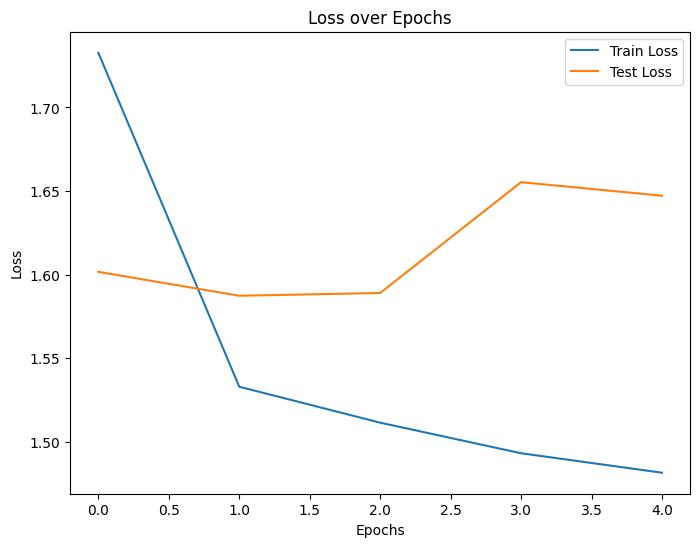

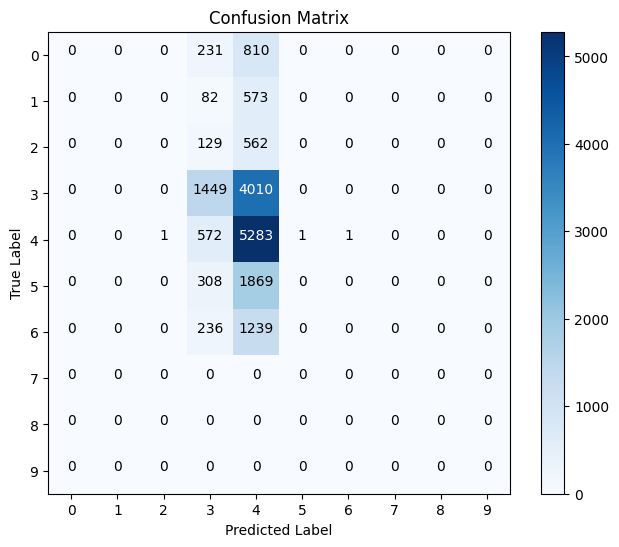

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


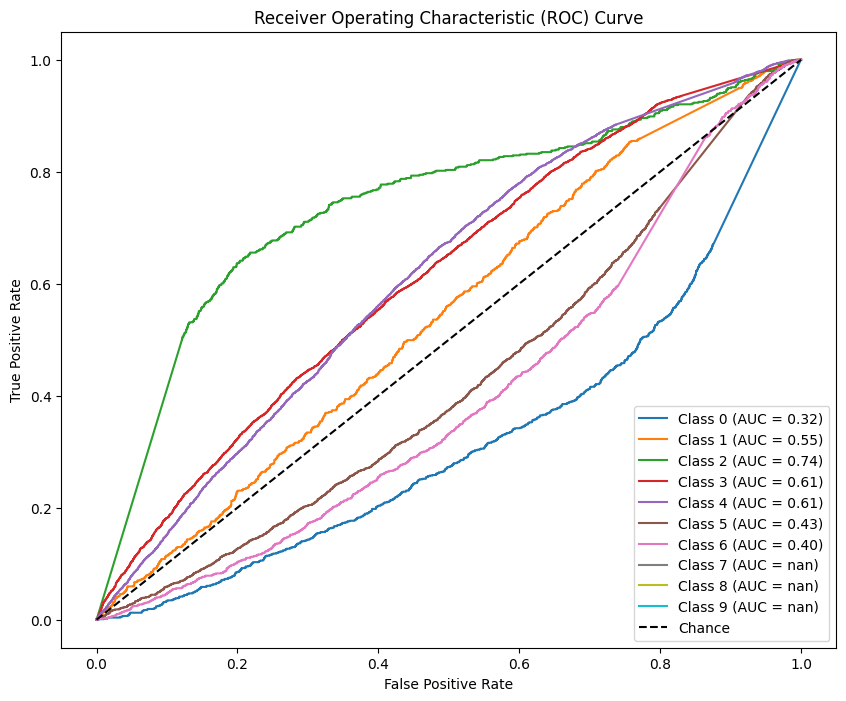

In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from itertools import chain

# Function to plot the ROC curve
def plot_roc_curve(model, data_loader, n_classes):
    model.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            y_true.extend(labels.numpy())
            y_score.extend(outputs.numpy())

    # One-hot encode labels
    y_true_one_hot = np.eye(n_classes)[y_true]

    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], np.array(y_score)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="best")
    plt.show()

# Function to calculate and store losses over epochs
def training_loop_with_loss(n_epochs, optimizer, model, loss_fn, train_loader, test_loader):
    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()

        # Save losses
        train_losses.append(train_loss / len(train_loader))
        test_losses.append(test_loss / len(test_loader))

        # Print loss for the epoch
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    return train_losses, test_losses

# Plotting losses
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.show()

# Confusion matrix function
def plot_confusion_matrix(model, data_loader, n_classes):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    cm = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)))
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, range(n_classes))
    plt.yticks(tick_marks, range(n_classes))

    # Annotate confusion matrix
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f'{cm[i, j]}', horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.show()

# Updated model training and evaluation
torch.manual_seed(0)
model = neural_network(3*224*224, 128, 64, 10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Training the model and capturing losses
train_losses, test_losses = training_loop_with_loss(
    n_epochs=5, optimizer=optimizer, model=model, loss_fn=loss_fn,
    train_loader=train_loader_emotion, test_loader=test_loader_emotion
)

# Plot losses
plot_losses(train_losses, test_losses)

# Plot confusion matrix for test data
plot_confusion_matrix(model, test_loader_emotion, n_classes=10)

# Plot ROC curve for test data
plot_roc_curve(model, test_loader_emotion, n_classes=10)
